In [1]:
#Importing the dataset 
import numpy as np 
import pandas as pd 
import os     #os module is used here for fetching the content of directory containing dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
#All the libraries/modules required to build face mask detection model
from bs4 import BeautifulSoup   #Beautiful soup for web scraping
import matplotlib.pyplot as plt
import os    
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2


# **DATA PREPROCESSING**

In [3]:
#Here this function is used to locate the face in the annotation provided to make predictions.
def generate_box(obj):                  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]   #coordinates of Face in  annotation (Just like Bounding Box)
#This function will convert categorical labels into numbers which are undertsandable by the model.
def generate_label(obj):  #generate_label function encodes the three classes and converts the labels into numbers.

    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0
#Using this generate_target function we parse the annotations file and get the objects out from them
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()       #we are reading the annotation file here in order to obtain the object under the object tag in annotation xml file.
        soup = BeautifulSoup(data, 'xml')   #BeautifulSoup is used for scraping the annotation file which is in xml format. Here soup is the object of BeautifulSoup
        objects = soup.find_all('object')   #find_all finds all the objects in annotation file for which the function is being called in the form of a list of strings.

        num_objs = len(objects)    #num_objs is an integer variable containing the total number of objects in an image.

        boxes = []
        labels = []     
        for i in objects:
            boxes.append(generate_box(i)) 
            #Now  the face coordinates of objects are being appended to box list
            labels.append(generate_label(i)) #And the associated labels(i.e masked ,not properly masked or Not masked )to labels (list).
            
        boxes=np.array(boxes)           #to convert the boxes(datatype:list) and labels(datatype:list) into numpy array which is accepted by a model.
        labels=np.array(labels)         
        img_id = np.array(image_id)     #img_id is the index of the image  in the dataset 
        target = {}
        target["boxes"] = boxes    #target is a dictionary having key as image array and values as the associated labels
        target["labels"] = labels
        
        return (target,num_objs)
    '''
    -->so basically this generate_target function has the following parameters:
       *image_id: It is the index/number of image in the image folder of dataset.
       *file: It is the path of the annotation file .
    -->This function returns target which is a dictionary:{key:value}
       * Here key :boxes(i.e face coordinates which is the region of interest in the whole image )
       * Here value:labels associated with 
    
    '''

In [4]:
imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))
len(imgs)     #there are in total 853 images in image folder

853

In [5]:
labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))
len(labels)           #853 annotations

853

In [6]:
# Here we use the above functions and save results in lists
targets=[]     #stores face coordinates
numobjs=[]     #stores number of faces in each image
#run the loop for number of images we have
for i in range(0,853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/kaggle/input/face-mask-detection/images/", file_image)  #it concatenates the path contents.
    label_path = os.path.join("/kaggle/input/face-mask-detection/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)   
    targets.append(target)
    numobjs.append(numobj)

In [7]:
type(target)

dict

In [8]:
type(numobj)

int

In [9]:
numobjs[0]   #there are three faces in image 0 for which labeling has been done 

3

In [10]:
print(targets[:5])    #targets is a list which contains all the face coordinates and labels of all objects in each and every annotation fil

[{'boxes': array([[ 79, 105, 109, 142],
       [185, 100, 226, 144],
       [325,  90, 360, 141]]), 'labels': array([0, 1, 0])}, {'boxes': array([[321,  34, 354,  69],
       [224,  38, 261,  73],
       [299,  58, 315,  81],
       [143,  74, 174, 115],
       [ 74,  69,  95,  99],
       [191,  67, 221,  93],
       [ 21,  73,  44,  93],
       [369,  70, 398,  99],
       [ 83,  56, 111,  89]]), 'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 0])}, {'boxes': array([[ 68,  42, 105,  69],
       [154,  47, 178,  74],
       [238,  34, 262,  69],
       [333,  31, 366,  65]]), 'labels': array([1, 1, 1, 2])}, {'boxes': array([[ 52,  53,  73,  76],
       [ 72,  53,  92,  75],
       [112,  51, 120,  68],
       [155,  60, 177,  83],
       [189,  59, 210,  80],
       [235,  57, 257,  78],
       [289,  60, 309,  83],
       [313,  68, 333,  90],
       [351,  35, 364,  59]]), 'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1])}, {'boxes': array([[ 70, 185, 176, 321]]), 'labels': array([1])}]


In [11]:
# length of target is 853
print(targets[0])    #There are in total three faces in the first image out of which two are not wearing a mask and the third person is wearing a mask properly.  
print(type(targets))     

{'boxes': array([[ 79, 105, 109, 142],
       [185, 100, 226, 144],
       [325,  90, 360, 141]]), 'labels': array([0, 1, 0])}
<class 'list'>


In [12]:
import cv2     #For computer vision.
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array    #for converting image format to numpy array format which is acceptible by the model
from tensorflow import keras
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"../input/face-mask-detection/images/maksssksksss{}.png".format(i)   #this will give the following image path:/input/face-mask-detection/images/maksssksksssi.png
    #read image from specified file path
    img = cv2.imread(img_path)  
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]    # 0-->xmin , 1-->ymin , 2-->xmax , 3-->ymax   (with the help of this command the face is obtained in img1)
        img1 = cv2.resize(img1, (224, 224))   # here the face obtained is resized to (224,224) pixels
        img1 = img_to_array(img1)      #Now the image so obtained is converted into array.
        #img1 = preprocess_input(img1) 
        face_images.append(img1)   # we have our required image in array form 
        face_labels.append(targets[i]['labels'][j])   #and these are the labels that are associated with it

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)
'''cv2.imread() method loads an image from the specified file. 
If the image cannot be read (because of missing file, improper permissions, unsupported or invalid format) 
then this method returns an empty matrix.'''

'cv2.imread() method loads an image from the specified file. \nIf the image cannot be read (because of missing file, improper permissions, unsupported or invalid format) \nthen this method returns an empty matrix.'

In [13]:
len(face_images)   #the no. of faceImages and the labels associated with it are the same

4072

In [14]:
len(face_labels)

4072

In [15]:
#For counting the datapoints lying in each class.
unique, counts = np.unique(face_labels, return_counts=True)    
dict(zip(unique, counts))   


{0: 717, 1: 3232, 2: 123}

In [16]:
#Encode the labels in one hot encode form 
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)    
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

DATA AUGMENTATION

In [17]:
#Perform data augmentation to increase the data for training the model.   #Here aug is the object of ImageDataGenerator.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,   
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,     
    fill_mode="nearest"    #the most imp. parameter of ImageDataGenerator
    )

In [18]:
INIT_LR = 1e-4     #this is the learning rate .Default learning rate is 0.001 for Adam.
EPOCHS = 20        #The model will run for 20 times
BS = 32            #Standard batch size is 32.

In [19]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

# SPLITTING DATA INTO TRAIN &TEST SET

In [20]:
face_images

array([[[[122., 113., 126.],
         [122., 113., 126.],
         [122., 113., 126.],
         ...,
         [133., 133., 157.],
         [133., 133., 157.],
         [133., 133., 157.]],

        [[122., 113., 126.],
         [122., 113., 126.],
         [122., 113., 126.],
         ...,
         [133., 133., 157.],
         [133., 133., 157.],
         [133., 133., 157.]],

        [[122., 113., 126.],
         [122., 113., 126.],
         [122., 113., 126.],
         ...,
         [133., 133., 157.],
         [133., 133., 157.],
         [133., 133., 157.]],

        ...,

        [[ 34.,  31.,  47.],
         [ 34.,  31.,  47.],
         [ 34.,  31.,  47.],
         ...,
         [ 53.,  42.,  82.],
         [ 53.,  42.,  82.],
         [ 53.,  42.,  82.]],

        [[ 34.,  31.,  47.],
         [ 34.,  31.,  47.],
         [ 34.,  31.,  47.],
         ...,
         [ 53.,  42.,  82.],
         [ 53.,  42.,  82.],
         [ 53.,  42.,  82.]],

        [[ 34.,  31.,  47.],
       

In [21]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

Normalize the training and testing data to get better results

In [22]:
# Dividingthe  train and test images by the maximum value (normalize it)
trainX = trainX / 255.0
testX = testX / 255.0

# The min and max values of the training data
trainX.min(), trainX.max()

(0.0, 1.0)

In [23]:
trainX.shape

(3257, 224, 224, 3)

In [24]:
trainY.shape

(3257, 3)

In [25]:
trainX[0].shape

(224, 224, 3)

In [26]:
trainY[0].shape

(3,)

In [27]:
del targets,face_images,face_labels     #as we have no use for them

# BUILDING  A MODEL

In [28]:
# Set random seed
tf.random.set_seed(42)    
#Relu: if input is negative it returns a zero and if input is positive it gives the same element(i.e without any modification)
model_1 = keras.models.Sequential([     #keras Sequential API has been used
    keras.layers.Conv2D(filters = 5, kernel_size = 3, activation = 'relu', 
                        input_shape = (224,224,3)),    #filter : 5 (randomly alloted)
    keras.layers.Conv2D(filters = 5, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),   #to reduce the dimension of feature map MaxPool is used which will chose the highest of element from the region of the feature map covered by the filter.
    keras.layers.Conv2D(filters = 5, kernel_size = 3, activation = 'relu'),
    keras.layers.Conv2D(filters = 5, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 3, activation = 'softmax')   #units =3 because 3 classes are there: 1.Masked
                                                            #                                      2.with mask but  incorrectluy
])                                                          #                                      3.without mask


'''
The flatten layer is used so as to convert our final feature map(after pooling) into a linear 1-D array
as  the next layer  is the dense layer 
which accepts 1 D tensors only.
'''

'\nThe flatten layer is used so as to convert our final feature map(after pooling) into a linear 1-D array\nas  the next layer  is the dense layer \nwhich accepts 1 D tensors only.\n'

# COMPILING AND FITTING A MODEL

In [29]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#helps in optimization and generalization.
model_1.compile(loss="categorical_crossentropy", optimizer=opt,     #as this is a multi-class classification problem thats why we have used categorical crossentropy.
	metrics=["accuracy"])
H = model_1.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY), 
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

#Class having high weight will be considered more importat while training

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
101/101 [==============================] - 41s 329ms/step - loss: 0.6101 - accuracy: 0.7867 - val_loss: 0.5585 - val_accuracy: 0.7939
Epoch 2/20
101/101 [==============================] - 33s 330ms/step - loss: 0.5317 - accuracy: 0.7932 - val_loss: 0.4894 - val_accuracy: 0.7939
Epoch 3/20
101/101 [==============================] - 33s 326ms/step - loss: 0.3858 - accuracy: 0.8481 - val_loss: 0.3284 - val_accuracy: 0.8920
Epoch 4/20
101/101 [==============================] - 33s 324ms/step - loss: 0.2926 - accuracy: 0.9119 - val_loss: 0.2901 - val_accuracy: 0.9141
Epoch 5/20
101/101 [==============================] - 33s 322ms/step - loss: 0.2586 - accuracy: 0.9219 - val_loss: 0.2634 - val_accuracy: 0.9202
Epoch 6/20
101/101 [==============================] - 33s 323ms/step - loss: 0.2382 - accuracy: 0.9293 - val_loss: 0.2572 - val_accuracy: 0.9239
Epoch 7/20
101/101 [==============================] - 33s 323ms/step - loss: 0.2236 - accuracy: 0.9343 - val_loss: 0.2485 - val_ac

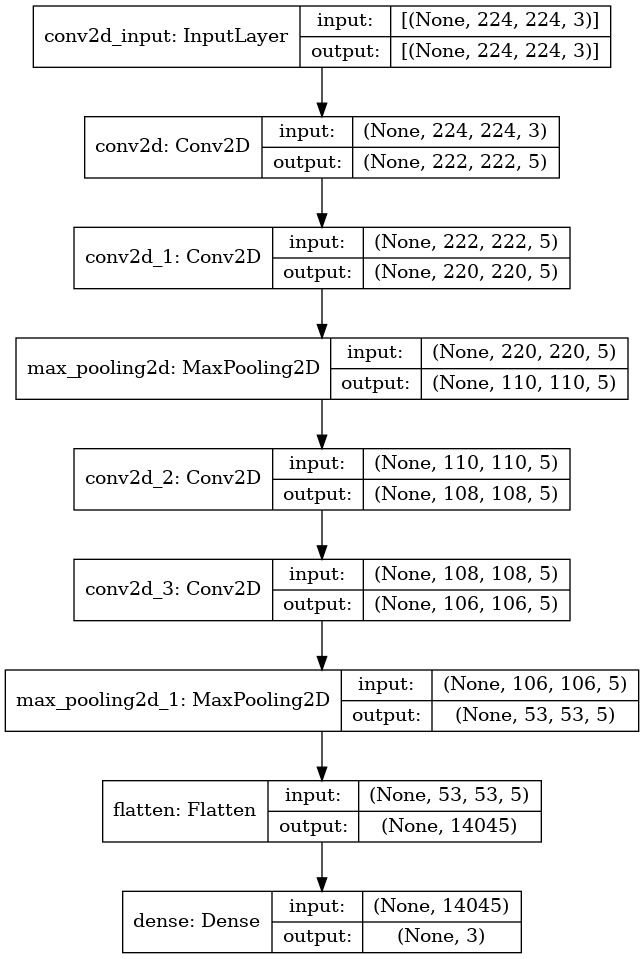

In [30]:
from tensorflow.keras.utils import plot_model

plot_model(model_1, show_shapes=True)

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 5)       140       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 5)       230       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 5)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 5)       230       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 5)       230       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 14045)             0

**IMPROVING THE MODEL (TWEAKING THE PREVIOUS MODEL TO GET BETTER ACCURACY)**

In [32]:
# Set random seed
tf.random.set_seed(42)

model_2 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu', 
                        input_shape = (224,224,3)),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.Conv2D(filters = 10,  kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 3, activation = 'softmax')  
])

In [33]:
EPOCHS=30

In [34]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)    #decay rate is being used here to reduce the learning rate with each epoch.
model_2.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model_2.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,   #it is the number of steps to yield before declaring one epoch finished and starting a new one.
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS) 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
101/101 [==============================] - 35s 340ms/step - loss: 0.6113 - accuracy: 0.7885 - val_loss: 0.5173 - val_accuracy: 0.7939
Epoch 2/30
101/101 [==============================] - 33s 324ms/step - loss: 0.3436 - accuracy: 0.8847 - val_loss: 0.3092 - val_accuracy: 0.9092
Epoch 3/30
101/101 [==============================] - 33s 323ms/step - loss: 0.2550 - accuracy: 0.9209 - val_loss: 0.2625 - val_accuracy: 0.9190
Epoch 4/30
101/101 [==============================] - 33s 326ms/step - loss: 0.2235 - accuracy: 0.9299 - val_loss: 0.2305 - val_accuracy: 0.9276
Epoch 5/30
101/101 [==============================] - 33s 325ms/step - loss: 0.2221 - accuracy: 0.9333 - val_loss: 0.2258 - val_accuracy: 0.9276
Epoch 6/30
101/101 [==============================] - 33s 325ms/step - loss: 0.2152 - accuracy: 0.9315 - val_loss: 0.2218 - val_accuracy: 0.9276
Epoch 7/30
101/101 [==============================] - 33s 327ms/step - loss: 0.2035 - accuracy: 0.9408 - val_loss: 0.2180 - val_ac

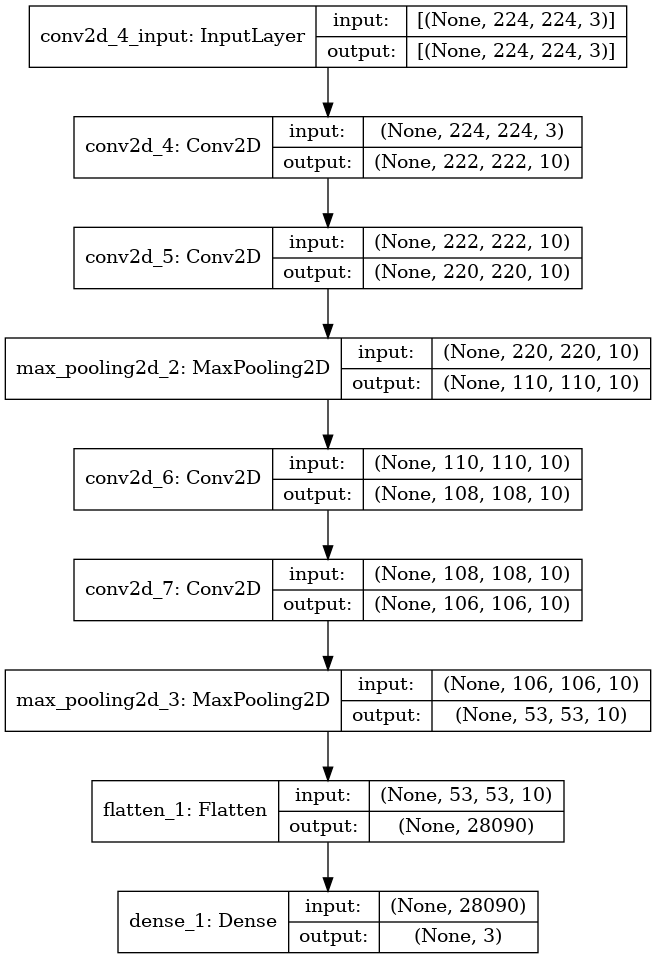

In [35]:
from tensorflow.keras.utils import plot_model

plot_model(model_2, show_shapes=True)

In [36]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28090)            

# PREDICTIONS

In [37]:
'''Our model outputs a list of prediction probabilities meaning,
it outputs a number for how likely it thinks a particular class is to be the label.
The higher the number in the prediction probabilities list, the more likely the 
model believes that is the right class.'''
ProbsY = model_1.predict(testX)
print(ProbsY)

[[5.1063823e-04 9.8797649e-01 1.1512833e-02]
 [3.3836491e-02 9.3262237e-01 3.3541143e-02]
 [8.9830470e-01 8.7700158e-02 1.3995190e-02]
 ...
 [6.7762977e-07 9.9945039e-01 5.4889015e-04]
 [1.3897440e-01 8.3564872e-01 2.5376894e-02]
 [1.6220417e-02 9.6415418e-01 1.9625517e-02]]


In [38]:
# Converting all of the predictions from probabilities to labels
PredictionY = ProbsY.argmax(axis=1)    

# View the first 10 prediction labels
PredictionY[:10]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [39]:
#These are the classes
class_names=["without_mask","with_mask","mask_weared_incorrect"]   

In [40]:
# See the predicted class number and associated label
ProbsY[20].argmax(), class_names[ProbsY[20].argmax()]

(1, 'with_mask')

MODEL_1

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       143
           1       0.96      0.97      0.97       647
           2       0.50      0.04      0.07        25

    accuracy                           0.94       815
   macro avg       0.77      0.66      0.65       815
weighted avg       0.93      0.94      0.93       815



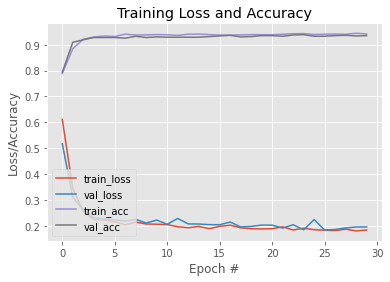

In [41]:
print("[INFO] evaluating network...")
predIdxs = model_1.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

MODEL_2

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       143
           1       0.96      0.97      0.96       647
           2       0.50      0.20      0.29        25

    accuracy                           0.93       815
   macro avg       0.77      0.69      0.71       815
weighted avg       0.93      0.93      0.93       815



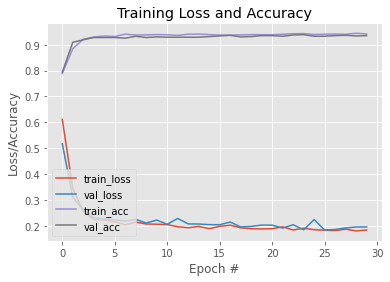

In [42]:
print("[INFO] evaluating network...")
predIdxs = model_2.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()